### 5.1. Setup

Install required text processing libraries for the example

In [1]:
import nltk

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### 5.2. Creating Text Representations

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [2]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [3]:
#Load Spam Data and review content
spam_data = pd.read_csv("Spam-Classification.csv")

print("\nLoaded Data :\n------------------------------------")
print(spam_data.head())

#Separate feature and target data
spam_classes_raw = spam_data["CLASS"]
spam_messages = spam_data["SMS"]


Loaded Data :
------------------------------------
  CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


In [4]:
#Custom tokenizer to remove stopwords and use lemmatization
lemmatizer = WordNetLemmatizer()
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)
#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)
#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

C:\Users\LENOVO\tf-env\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(spam_classes_raw)

#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)

TF-IDF Matrix Shape :  (1500, 4568)
One-hot Encoding Shape :  (1500, 2)


### 5.3. Building and Evaluating the Model

In [7]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

In [8]:
#Setup Hyper Parameters for building the model
NB_CLASSES=2
N_HIDDEN=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN, 
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\LENOVO\tf-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)               │ (None, 32)                  │         146,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,330 (575.51 KB)

 Trainable params: 147,330 (575.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)


Training Progress:
------------------------------------
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5168 - loss: 0.6919 - val_accuracy: 0.7481 - val_loss: 0.6857
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7893 - loss: 0.6818 - val_accuracy: 0.8889 - val_loss: 0.6705
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9121 - loss: 0.6630 - val_accuracy: 0.9444 - val_loss: 0.6477
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9641 - loss: 0.6360 - val_accuracy: 0.9519 - val_loss: 0.6193
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9752 - loss: 0.6026 - val_accuracy: 0.9593 - val_loss: 0.5865
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9786 - loss: 0.5627 - val_accuracy: 0.9556 - val_loss: 0.5498
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9845 - loss: 0.5194 - val_accuracy: 0.9519 - val_loss: 0.5097
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9824 


Accuracy during Training :
------------------------------------


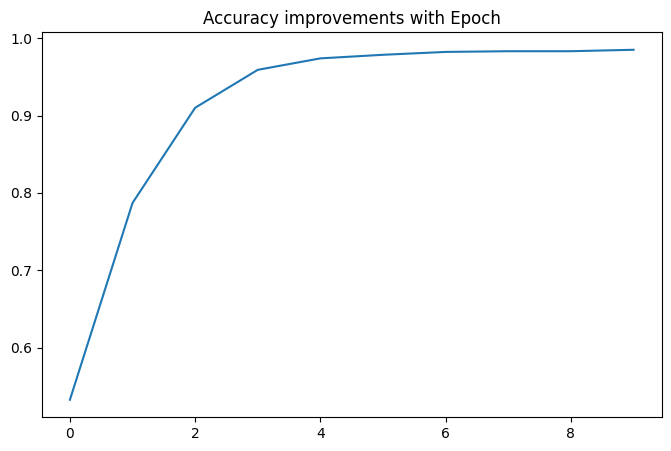


Evaluation against Test Dataset :
------------------------------------
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9431 - loss: 0.4053


[0.4157520532608032, 0.9333333373069763]

In [10]:
import matplotlib.pyplot as plt
print("\nAccuracy during Training :\n------------------------------------")

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
#plt.savefig("accuracy_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

### 5.4. Predicting for Text

In [11]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest",
                                    "Yup I will come over"]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4568)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction Output: [1 0]
Prediction Classes are  ['spam' 'ham']
